# LinkedIn Job Skills Analysis
      
This analysis draws on text scraped from the “My Jobs” section of my LinkedIn account—so rather than representing every data‑science vacancy, it reflects my personal interests and opportunities within the U.K. job market. The goal is to surface the skills and tools that matter most in this specific slice of the job market, and to inform upskilling decisions that boost employability and earning potential.

Rather than relying on raw term frequencies — which can be skewed by domain‑specific hiring volumes — I operationalise “importance” through **transversality**: the extent to which a skill bridges multiple domains across the data‑science spectrum. A highly transversal skill enables you to:

* **Adapt rapidly** across roles and teams promoting versatiliy and employability

* **Weather market shifts** better than narrowly focused specialists

* **Step into leadership** by designing and orchestrating end‑to‑end data solutions

The workflow is as follows:

1. **Text extraction & normalization**
Clean and standardise skill mentions using a custom ontology.

2. **Co‑occurrence & clustering**
Compute an NPMI matrix of skill co‑mentions, then identify statistically robust clusters (e.g. data engineering, statistical analysis, machine learning).

3. **Transversality scoring**
Measure each skill’s entropy‑based affinity across those stable clusters to quantify its cross‑domain reach.

4. **Top bridge skills**
Highlight the ten most transversal competencies — beyond Python — that unlock the greatest versatility and market value in this localised dataset.

### Import libraries

In [1]:
import sys
import os
import re
from typing import List, Dict
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib import rc
from matplotlib.cm import ScalarMappable
from wordcloud import WordCloud
from textwrap import wrap

# Need to add the src directory to the path to import the skills_analysis module
sys.path.append(os.path.join(os.getcwd(), "../src"))

from skills_analysis import (
                                load_and_parse_requirements,
                                extract_noun_phrases,
                                clean_phrases,
                                filter_phrases_by_df,
                                map_phrases_to_clusters,
                                replace_keywords_with_language,
                                load_skill_ontologies,
                                filter_by_ontologies,
                                _normalise
                            )
       

### Define supporting functions

In [2]:
def plot_skill_frequency(skill_df: pd.DataFrame, top_n: int = 10) -> None:
    """Plot bar chart of top N skills by number of postings."""
    top = skill_df.sort_values("freq", ascending=False).head(top_n)
    plt.figure(figsize=(8, 5))
    plt.barh(top["term"][::-1], top["freq"][::-1])
    plt.xlabel("Number of Postings")
    plt.title(f"Top {top_n} Skills by Postings")
    plt.tight_layout()
    plt.show()


def plot_cooccurrence_heatmap(
    df: pd.DataFrame, key_terms: List[str], text_col: str = "req_text"
) -> None:
    """Display a heatmap of term co-occurrence for selected key_terms."""
    cooc = pd.DataFrame(0, index=key_terms, columns=key_terms)
    for text in df[text_col].dropna().str.lower():
        present = [t for t in key_terms if t in text]
        for i in present:
            for j in present:
                cooc.loc[i, j] += 1
    plt.figure(figsize=(7, 6))
    plt.imshow(cooc, aspect="equal")
    plt.xticks(range(len(key_terms)), key_terms, rotation=90)
    plt.yticks(range(len(key_terms)), key_terms)
    plt.colorbar(label="Co-occurrence")
    plt.title("Skill Co-occurrence Heatmap")
    plt.tight_layout()
    plt.show()


def plot_demand_vs_supply(cluster_df: pd.DataFrame) -> None:
    """Scatter plot of cluster demand vs. supply (avg. applicants)."""
    plt.figure(figsize=(6, 6))
    plt.scatter(cluster_df["demand"], cluster_df["avg_applicants"])
    for _, row in cluster_df.iterrows():
        plt.text(row["demand"], row["avg_applicants"], row["cluster"], fontsize=9)
    plt.axhline(cluster_df["avg_applicants"].mean(), linestyle="--")
    plt.axvline(cluster_df["demand"].mean(), linestyle="--")
    plt.xlabel("Demand (Postings)")
    plt.ylabel("Supply (Avg Applicants)")
    plt.title("Cluster Demand vs. Supply")
    plt.tight_layout()
    plt.show()


In [3]:
def plot_word_cloud(phrases: List[List[str]], save_plot: bool = False) -> None:
    """Generate and display a word cloud from the provided phrases."""
    
    # Flatten and count frequencies
    freq = Counter(w for sub in phrases for w in sub)

    # Dimensions
    width = height = 800

    wc = WordCloud(
        width=width,
        height=height,
        background_color="white",
        color_func=lambda *args, **kwargs: "black",
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save_plot: plt.savefig('../assets/wordcloud.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_lollipop_chart(skill_df: pd.DataFrame, save_plot: bool = False) -> None:
    """
    Creates a lollipop plot with stems and markers scaled by frequency.
    Skills are placed to the right of the markers, and sorted by frequency within each cluster.
    It includes a header and footer text.
    The style is loosely inspired by the BBC visualisation theme.
    """
    
    # Set font for the plot
    rc("font",**{"family":"sans-serif","sans-serif":["Helvetica"]})
    
    # Sort data: first by cluster, then by frequency (descending)
    skill_df_sorted = skill_df.sort_values(by=["cluster", "freq"], ascending=[True, False])

    # Create y-axis positions
    skill_df_sorted["term_position"] = range(len(skill_df_sorted))
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Build color mapping
    palette = sns.color_palette("tab10", n_colors=skill_df_sorted["cluster"].nunique())
    cluster_color_mapping = {cluster: palette[i] for i, cluster in enumerate(skill_df_sorted["cluster"].unique())}
    
    # For the legend
    cluster_order = []
    
    # Draw stems and points
    for _, row in skill_df_sorted.iterrows():
        # Scale linewidth and marker size based on frequency
        line_width = 0.5 + (row["freq"] / skill_df_sorted["freq"].max()) * 3.5
        marker_size = 30 + (row["freq"] / skill_df_sorted["freq"].max()) * 80
        
        ax.hlines(
            y=row["term_position"],
            xmin=0,
            xmax=row["freq"],
            color=cluster_color_mapping[row["cluster"]],
            alpha=0.6,
            linewidth=line_width
        )
        ax.plot(
            row["freq"],
            row["term_position"],
            "o",
            markersize=marker_size / 10,
            color=cluster_color_mapping[row["cluster"]],
            markeredgewidth=0.5,
            markeredgecolor=cluster_color_mapping[row["cluster"]],
            alpha=0.8
        )
        # Place term labels to the right of the marker
        ax.text(
            row["freq"] + (skill_df_sorted["freq"].max() * 0.01),
            row["term_position"],
            row["term"],
            va="center",
            fontsize=10,
            color="black"
        )
        
        # Record cluster in order of appearance
        if row["cluster"] not in cluster_order:
            cluster_order.append(row["cluster"])

    # Customize axes
    ax.set_yticks([])  # No y-ticks
    ax.set_xticks(ax.get_xticks())
    ax.tick_params(axis="x", labelsize=11)
    
    sns.despine(left=True, bottom=False, ax=ax)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add title 
    fig.suptitle("Frequency and clustering of skills: No big suprises", fontsize=20, y=0.95, x=0.56, weight="bold", color="k")
    # Add header 
    fig.text(0.37, 0.86, ("Skills extracted from LinkedIn job posts I was personally interested in, grouped into broad skill clusters based on relative frequencies."
                           "\nThis snapshot is not meant to represent the entire job market but highlights recurring patterns in roles aligned with my interests."
                           "\nClustering appears coherent, with Python standing out as a core skill in data science, TensorFlow and PyTorch leading among machine"
                           "\nlearning frameworks, and Databricks emerging as a valuable asset in the cloud ecosystem."), 
             ha="left", fontsize=11, color="k")


    # Add subtitle (footer)
    fig.text(0.37, 0.01, "Terms are color-coded by cluster and sorted by descending frequency within each cluster.", 
             ha="left", fontsize=11, color="k")

    # X label
    ax.set_xlabel("Frequency", fontsize=14, labelpad=13)
    ax.set_xlim(0, skill_df_sorted["freq"].max() * 1.1)  # Add some space to the right

    # Prepare legend
    # Match cluster order in the plot for readibility
    handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cluster_color_mapping[cluster],
                markeredgecolor=cluster_color_mapping[cluster], markersize=8, linestyle="None", label=cluster)
    for cluster in reversed(cluster_order) # Matplotlib plots from bottom to top
    ]

    ax.legend(
        handles=handles,
        title="Skill clusters",
        loc="best",
        frameon=False,
        fontsize=11,
        title_fontsize=13,
        bbox_to_anchor=(0.5, 0., 0.4, 0.5)
    )

    # Increase margins
    plt.subplots_adjust(left=0.4, right=0.9, top=0.86, bottom=0.09)  
    if save_plot: plt.savefig('../assets/clusters_freq.jpg', dpi=300)
    
    plt.show()

In [5]:
def extract_days(posted: str) -> int:
    """
    Converts relative time strings (like 'Reposted1 week ago') into estimated number of days.
    Assumes:
        - 1 week = 7 days
        - 1 month = 30 days
    """
    if pd.isnull(posted):
        return None

    # Remove 'Reposted' prefix if it exists
    posted = posted.replace("Reposted", "").strip()

    # Match number and unit using regex
    match = re.match(r"(\d+)\s*(week|month|day)s?\s+ago", posted)
    if not match:
        return None

    num, unit = int(match.group(1)), match.group(2)

    if unit == "day":
        return num
    elif unit == "week":
        return num * 7
    elif unit == "month":
        return num * 30
    else:
        return None




In [6]:
def filter_other_terms_normalised(
    filtered: List[List[str]],
    skill_df: pd.DataFrame,
    _normalise: callable
) -> List[List[str]]:
    """
    Apply `_normalise` to each term in `filtered` and remove any term whose
    normalized form is in `skill_df` with cluster == "Other".
    Returns a new list of filtered phrase lists.
    """
    # build set of normalised "Other" terms
    other_norms = {
        _normalise(raw_term)
        for raw_term in skill_df.loc[skill_df["cluster"] == "Other", "term"]
    }

    cleaned: List[List[str]] = []
    for doc in filtered:
        new_doc: List[str] = []
        for term in doc:
            norm = _normalise(term)
            if norm not in other_norms:
                new_doc.append(term)
        cleaned.append(new_doc)

    return cleaned

In [7]:

def compute_npmi_from_filtered(filtered: List[List[str]]) -> pd.DataFrame:
    """
    Compute normalised pointwise mutual information (NPMI) from a list of phrase lists,
    one list per document. Returns a symmetric DataFrame whose rows and columns
    are the sorted unique phrases.
    """
    key_terms = sorted({t for doc in filtered for t in doc})
    n_docs = len(filtered)

    # build binary document-term matrix
    bin_mat = np.zeros((n_docs, len(key_terms)), dtype=int) 
    term_idx = {t: i for i, t in enumerate(key_terms)}
    for doc_i, phrases in enumerate(filtered):
        for p in set(phrases):
            bin_mat[doc_i, term_idx[p]] = 1

    # marginals and joints
    p_i = bin_mat.sum(axis=0) / n_docs # terms marginal probability
    p_ij = (bin_mat.T @ bin_mat) / n_docs # terms joint probability

    # compute NPMI (-1: never co-occur, 0: independent, 1: fully dependent)
    npmi = pd.DataFrame(index=key_terms, columns=key_terms, dtype=float)
    for i, ti in enumerate(key_terms):
        for j, tj in enumerate(key_terms):
            pij = p_ij[i, j]
            if pij <= 0:
                npmi.iat[i, j] = 0.0
            else:
                pmi = np.log2(pij / (p_i[i] * p_i[j])) # calculate pointwise mutual information
                npmi.iat[i, j] = pmi / (-np.log2(pij)) # normalise by the joint self-information
    return npmi


def term_clusters(npmi: pd.DataFrame, num_clusters: int = 4) -> pd.Series:
    """
    Assign each term to a flat cluster label based on hierarchical clustering 
    of the NPMI matrix. Returns a Series mapping term -> cluster label.
    """
    # Compute the distance matrix
    dist = 1.0 - npmi.values # distance = 1 - similarity
    # Fill the diagonal with zeros
    np.fill_diagonal(dist, 0.0)
    # Compute condensed distance matrix (upper triangle of the distance matrix)
    # This is needed for the linkage function
    condensed = dist[np.triu_indices_from(dist, k=1)]
    # Compute linkage matrix using average linkage
    linkage_matrix = linkage(condensed, method="average")
    # Assign cluster labels
    # criterion="maxclust": form flat clusters
    labels = fcluster(linkage_matrix, t=num_clusters, criterion="maxclust")
    return pd.Series(labels, index=npmi.index.astype(str))


In [8]:
def bootstrap_cluster_stability(
    filtered: List[List[str]],
    num_clusters: int = 4,
    n_reps: int = 100,
    linkage_method: str = "average",
    random_state: int | None = 17
) -> pd.DataFrame:
    """
    Compute cluster‐stability proportions via document bootstrap, keeping
    a fixed term vocabulary.
    
    Returns a DataFrame P where P[i,j] is the fraction of bootstraps in
    which term i and term j landed in the same cluster.
    """
    # For reproducibility
    rng = np.random.RandomState(random_state)
    
    # Fix vocabulary and build original binary doc-term matrix
    all_terms = sorted({t for doc in filtered for t in doc})
    n_terms = len(all_terms)
    term_idx = {t: k for k, t in enumerate(all_terms)}
    n_docs = len(filtered)

    bin_mat = np.zeros((n_docs, n_terms), dtype=int)
    for di, phrases in enumerate(filtered):
        for p in set(phrases):
            bin_mat[di, term_idx[p]] = 1

    # helper to compute NPMI from a binary matrix with fixed vocab
    def npmi_from_bin(mat: np.ndarray) -> np.ndarray:
        p_i = mat.sum(axis=0) / mat.shape[0]
        p_ij = (mat.T @ mat) / mat.shape[0]
        with np.errstate(divide="ignore", invalid="ignore"):
            pmi = np.log(p_ij / (p_i[:, None] * p_i[None, :]))
            npmi = pmi / (-np.log(p_ij))
        npmi = np.nan_to_num(npmi)  # zero out NaNs and infs
        return npmi

    # accumulator for co-membership
    co_matrix = np.zeros((n_terms, n_terms), dtype=int)

    for _ in range(n_reps):
        # Resample docs with replacement
        idx = rng.choice(n_docs, size=n_docs, replace=True)
        boot_mat = bin_mat[idx, :]

        # Compute NPMI and distance
        npmi_boot = npmi_from_bin(boot_mat)
        dist = 1.0 - npmi_boot
        np.fill_diagonal(dist, 0.0)

        # 4) Condensed vector and clustering
        iu = np.triu_indices_from(dist, k=1)
        condensed = dist[iu]
        Z = linkage(condensed, method=linkage_method)
        labels = fcluster(Z, t=num_clusters, criterion="maxclust")

        # Update co-membership counts
        for i in range(n_terms):
            equal = (labels == labels[i])
            co_matrix[i, equal] += 1

    # Convert to proportions
    P = co_matrix / n_reps
    return pd.DataFrame(P, index=all_terms, columns=all_terms)



In [9]:
def filter_stable_clusters(
    stability_matrix: pd.DataFrame,
    clusters: Dict[int, List[str]],
    stability_threshold: float = 0.8
) -> Dict[int, List[str]]:
    """
    Given a term‐by‐term stability_matrix (co‐membership proportions) and
    a clusters dict (cluster_id -> list of terms), return a new dict
    containing only those clusters whose *average* internal stability 
    exceeds stability_threshold.
    """
    stable: Dict[int, List[str]] = {}
    for cid, members in clusters.items():
        if len(members) < 2:
            continue
        sub = stability_matrix.loc[members, members].values
        # only off-diagonal
        iu = np.triu_indices_from(sub, k=1)
        avg_stab = sub[iu].mean()
        if avg_stab >= stability_threshold:
            stable[cid] = members
    return stable


def transversal_scores_on_stable_clusters(
    npmi: pd.DataFrame,
    stability_matrix: pd.DataFrame,
    clusters: Dict[int, List[str]],
    stability_threshold: float = 0.8
) -> pd.Series:
    """
    Compute entropy‐based transversality scores *only* for clusters
    deemed stable. Clusters whose average bootstrap stability is below
    stability_threshold are dropped before calculating affinities.

    Returns a pd.Series of per-term entropy (higher = more transversal).
    """
    # 1) filter clusters by stability
    stable_clusters = filter_stable_clusters(
        stability_matrix, clusters, stability_threshold
    )

    # 2) build term→cluster mapping for only stable clusters
    term_to_cluster = {
        term: cid
        for cid, members in stable_clusters.items()
        for term in members
    }
    cluster_ids = sorted(stable_clusters.keys())
    K = len(cluster_ids)

    # 3) compute entropy per term, but only counting affinities to stable clusters
    scores: Dict[str, float] = {}
    for term in npmi.index:
        S = np.zeros(K, dtype=float)
        row = npmi.loc[term]
        for other, val in row.items():
            if other == term or val <= 0:
                continue
            cid = term_to_cluster.get(other)
            if cid is None:
                # ignore terms outside stable clusters
                continue
            idx = cluster_ids.index(cid)
            S[idx] += val

        total = S.sum()
        if total <= 0:
            scores[term] = 0.0
        else:
            p = S / total
            H = -np.sum(p[p > 0] * np.log(p[p > 0]))
            scores[term] = H

    return pd.Series(scores)

In [40]:
def plot_top_transversal_skills(
    trans_scores: pd.Series,
    top_n: int = 10,
    base_colors: list[str] | None = None,
    font_family: str = "Helvetica",
    title: str = "Top 10 Most Transversal Skills",
    sup_title: str = "Some text",
    footer: str = "Some text",
    save_plot: bool | None = True
) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot a polar bar chart (inspired to Tobias Stadler's work) of the top-N most transversal skills based on entropy scores.

    trans_scores is a Series indexed by skill name with entropy-based transversality scores.
    top_n selects how many skills to display (highest scores first).
    base_colors is an optional list of hex colors for the colormap; defaults to a 4-color palette.
    font_family sets the font for titles and labels.
    Returns the (figure, axes) for further customization or saving.
    
    """

    # Select top N
    top = trans_scores.sort_values(ascending=False).head(top_n)
    labels = top.index.to_list()
    values = top.values

    # Angles for each bar
    angles = np.linspace(0.25, 2 * np.pi - 0.005, len(values), endpoint=False)
    
    # Specify the colormap
    palette = base_colors or ["#6C5B7B", "#C06C84", "#F67280", "#F8B195"]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("transversal", palette, N=top_n)
    norm = mpl.colors.Normalize(vmin=values.min(), vmax=values.max())
    bar_colors = cmap(norm(values))

    # Styling
    grey12 = "#1f1f1f"
    plt.rcParams.update({
        "font.family": font_family, 
        "text.color": grey12})
    plt.rc("axes", unicode_minus=False)
    
    
    # Figure & axis
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={"projection": "polar"},
        facecolor="white"
    )
    ax.set_facecolor("white")
    ax.set_ylim(-values.max() / 3, values.max())
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)


    # Plot bars
    bars = ax.bar(
        angles,
        values,
        width=2 * np.pi / len(values) * 0.8,
        color=bar_colors,
        edgecolor="none",
        linewidth=0.5,
        alpha=0.9,
        zorder = 10
    )
    ax.vlines(angles, 0, values.max()*0.9, color=grey12, ls=(1, (4, 4)), zorder=11)

    # Add radial gridlines for reference
    ax.set_yticks([values.min(), values.mean(), values.max()])
    ax.set_yticks(np.linspace(0, values.max()*0.9, 4), minor=False)
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle="-", color=grey12, alpha=0.2)

    # Remove tick marks, keep labels
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_xticks(angles)
    for tick in ax.xaxis.get_major_ticks(): tick.set_pad(18)
    wrapped_labels = ["\n".join(wrap(lbl, 10, break_long_words=False)) for lbl in labels]
    ax.set_xticklabels(wrapped_labels, fontsize=14, color=grey12, fontweight="bold")

    grid_vals = np.round(np.linspace(0, values.max()*0.9, 4),1)[1:]
    pad = -0.15
    x_pos = -0.1 * np.pi / 2
    for y in grid_vals:
        ax.text(
            x_pos,
            y + pad,
            f"{y}",
            ha="center",
            va="bottom",
            fontsize=12,
            color=grey12
        )
    # Add colorbar legend
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=ax,
        orientation="horizontal",
        pad=0.17,
        fraction=0.05,
        shrink=0.4
    )
    cbar.outline.set_visible(False)
    cbar.ax.xaxis.set_tick_params(size=0)
    cbar.set_label("Transversality Score (Entropy)", labelpad=-50, fontsize=12)
    
    cax = cbar.ax

    # Set custom end labels
    # Left at x=0, Right at x=1 in axis coordinates
    cax.text(
        -.14, 0.5,    # x, y in axis coords (y negative to place below bar)
        "Niche",
        transform=cax.transAxes,
        ha="left",
        va="center",
        fontsize=12,
        color=grey12
    )
    cax.text(
        1.27, 0.5,
        "Transversal",
        transform=cax.transAxes,
        ha="right",
        va="center",
        fontsize=12,

        color=grey12
    )

    # Add title
    fig.text(x=0.1, 
             y=1.05, 
             s=title, 
             fontsize=25, 
             weight="bold", 
             ha="left", 
             va="baseline")

    fig.suptitle(
        t=sup_title,
        x=0.1,
        y=1.01,
        fontsize=13,
        color=grey12,
        ha="left"
    )
    
    fig.text(x=0.5,
             y=-0.05, 
             s=footer, 
             fontsize=13, 
             ha="center", 
             va="baseline")


    plt.tight_layout()
    
    if save_plot: plt.savefig('../assets/trasversal_skills.png', dpi=300, bbox_inches='tight')

    return fig, ax


In [42]:
def plot_npmi_clusters(
    npmi_df: pd.DataFrame,
    term_to_cluster: pd.Series,
    title: str | None = 'some text',
    sup_title: str | None = 'some text',
    footer: str | None = 'some text',
    save_plot: bool | None = False
) -> None:
    """
    Plot a clustered heatmap of the NPMI matrix with side-colors for clusters,
    custom titles, and footer.

    Args:
        npmi_df: symmetric NPMI DataFrame (index and columns are term names).
        term_to_cluster: Series mapping each term (index) to an integer cluster label.
        title: Bold main title placed above the heatmap.
        sup_title: Subtitle in smaller font above the heatmap.
        footer: Footer text placed below the heatmap.
    """
    # Prepare cluster palette and term‐color mapping
    clusters = term_to_cluster
    unique_labels = sorted(clusters.unique())
    palette = sns.color_palette("tab10", n_colors=len(unique_labels))
    lut = {lab: palette[i] for i, lab in enumerate(unique_labels)}
    term_colors = clusters.map(lut)

    # Draw clustermap
    g = sns.clustermap(
        npmi_df,
        method="average",
        metric="euclidean",
        center=0,
        cmap="vlag",
        row_colors=term_colors,
        col_colors=term_colors,
        dendrogram_ratio=(.1, .1),
        cbar_pos=(.02, .32, .03, .2),
        linewidths=.7,
        figsize=(12, 13),
        yticklabels=1,
        xticklabels=1
    )

    # Re‐label y‐ticks with cluster
    row_inds = g.dendrogram_row.reordered_ind
    orig_labels = npmi_df.index.tolist()
    new_labels = [orig_labels[i] for i in row_inds]
    new_labels_with_cluster = [
        f"{label} (c{clusters[label]})" for label in new_labels
    ]
    g.ax_heatmap.set_yticklabels(new_labels_with_cluster, rotation=0, fontsize=9)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=9)

    # Remove y‐tick marks
    g.ax_heatmap.tick_params(axis="y", which="both", length=0)

    # Colorbar label
    cbar = g.cax  # seaborn stores the colorbar axis here
    cbar.set_title("NPMI", loc="left", fontsize=12)

    # Remove extra dendrogram and set col‐dendrogram title
    g.ax_row_dendrogram.remove()

    # Figure‐level titles and footer
    fig = g.figure
    fig.text(
        0, 1.1, title,
        fontsize=25, weight="bold",
        ha="left", va="baseline"
    )
    fig.text(
        0, 1.03, sup_title,
        fontsize=13, color="#1f1f1f",
        ha="left"
    )
    fig.text(
        0.5, -0.02, footer,
        fontsize=11,
        ha="center", va="baseline"
    )
    if save_plot: plt.savefig('../assets/clusters.png', dpi=300, bbox_inches='tight')

    plt.show()
    

### Load scraped data and ontologies

In [11]:

df = load_and_parse_requirements("../data/linkedin_job_requirements.csv", requirements_col="requirements")
df.head()

,posted,location,num_applicants,requirements,req_text
0,1 week ago,"London, England, United Kingdom",Over 100 people clicked apply,"{""What you bring:"": [""MS or PhD in Machine Lea...","{""what you bring:"": [""ms or phd in machine lea..."
1,Reposted1 week ago,"London, England, United Kingdom",Over 100 people clicked apply,"{""What we're looking for:"": [""Education: Maste...","{""what we're looking for:"": [""education: maste..."
2,Reposted4 weeks ago,"Maidenhead, England, United Kingdom",Over 100 applicants,"{""Experience:"": [""2+ years of experience in a ...","{""experience:"": [""2+ years of experience in a ..."
3,1 month ago,"Cambridge, England, United Kingdom",Over 100 people clicked apply,"{""Profile and Skills:"": [""PhD or equivalent ex...","{""profile and skills:"": [""phd or equivalent ex..."
4,1 month ago,United Kingdom,Over 100 people clicked apply,"{""Requirements"": [""have a degree in mathematic...","{""requirements"": [""have a degree in mathematic..."


In [12]:
missing_rows = df[df.isnull().any(axis=1)]
# Only one row is empty, so we can drop it
df.dropna(inplace=True)
print(missing_rows)

        posted                          location num_applicants requirements  \
6  4 weeks ago  Bristol, England, United Kingdom            NaN           {}   

  req_text  
6       {}  



The ontologies cover key domains in data science and engineering. Each domain contains a list of curated skill keyworkds.

In [13]:
ontos = load_skill_ontologies()
ontos.keys()

dict_keys(['data_science_practices', 'ml_techniques', 'statistical_techniques', 'ml_frameworks', 'devops', 'mlops', 'cloud', 'programming_languages'])

### Process text to extract skills & visualise frequencies

In [14]:
# Extract and process raw noun chunks
raw_phrases = extract_noun_phrases(df["req_text"].tolist())

# R, C++, C# need to be converted to R language, C++ language and C# language to avoid downstream issues, such as it being interpreted as a single letter
raw_phrases = replace_keywords_with_language(raw_phrases)

# Filter by document frequency (e.g., keep phrases between 1% and 80% of docs)
df_filtered = filter_phrases_by_df(raw_phrases)

# Filter out irrelevant or stop-word phrases by POS and token rules
cleaned = clean_phrases(df_filtered)

# Keeps only those phrases whose normalised form appear in the ontologies
filtered = filter_by_ontologies(cleaned, ontos, 0.95)

# Map each clean phrase to an ontology key domain (i.e., cluster):
skill_df = map_phrases_to_clusters(filtered, ontos)

# Remove 'other' cluster -> unidentified skills
skill_df = skill_df[skill_df['cluster'] != 'other']

skill_df.head()

,term,freq,cluster
0,python,20,programming_languages
1,pytorch,7,ml_frameworks
2,tensorflow,6,ml_frameworks
3,mlops practices,2,Other
4,electrical engineering,2,Other


In [15]:
# Extract number of applicants and lifetime of the job posting
df['num_applicants'] = df['num_applicants'].str.extract('(\d+)').fillna(0).astype(int)
df['days_ago'] =  df["posted"].apply(extract_days)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/mv/fvpjl0kn36g4b6ymmckwnwbc0000gn/T/ipykernel_5706/103266199.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['num_applicants'] = df['num_applicants'].str.extract('(\d+)').fillna(0).astype(int)


Just for fun, let's plot a wordcloud with the clean phrases

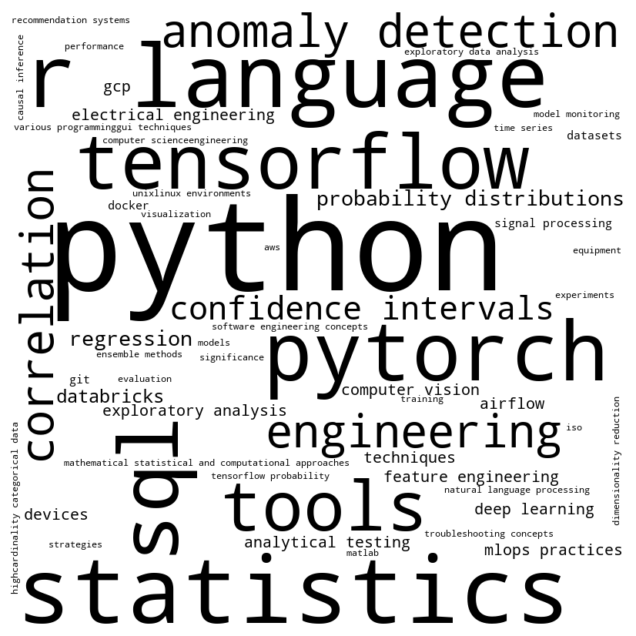

In [16]:
plot_word_cloud(filtered)


Plot overall more frequent skill terms

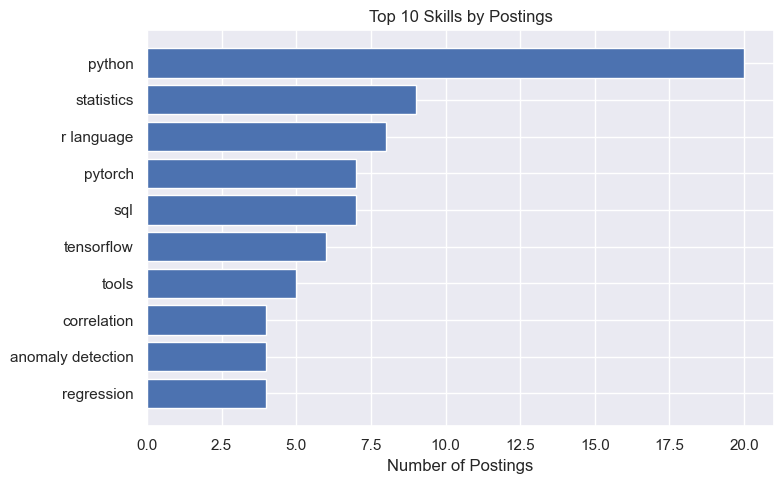

In [17]:
sns.set_theme()
plot_skill_frequency(skill_df)

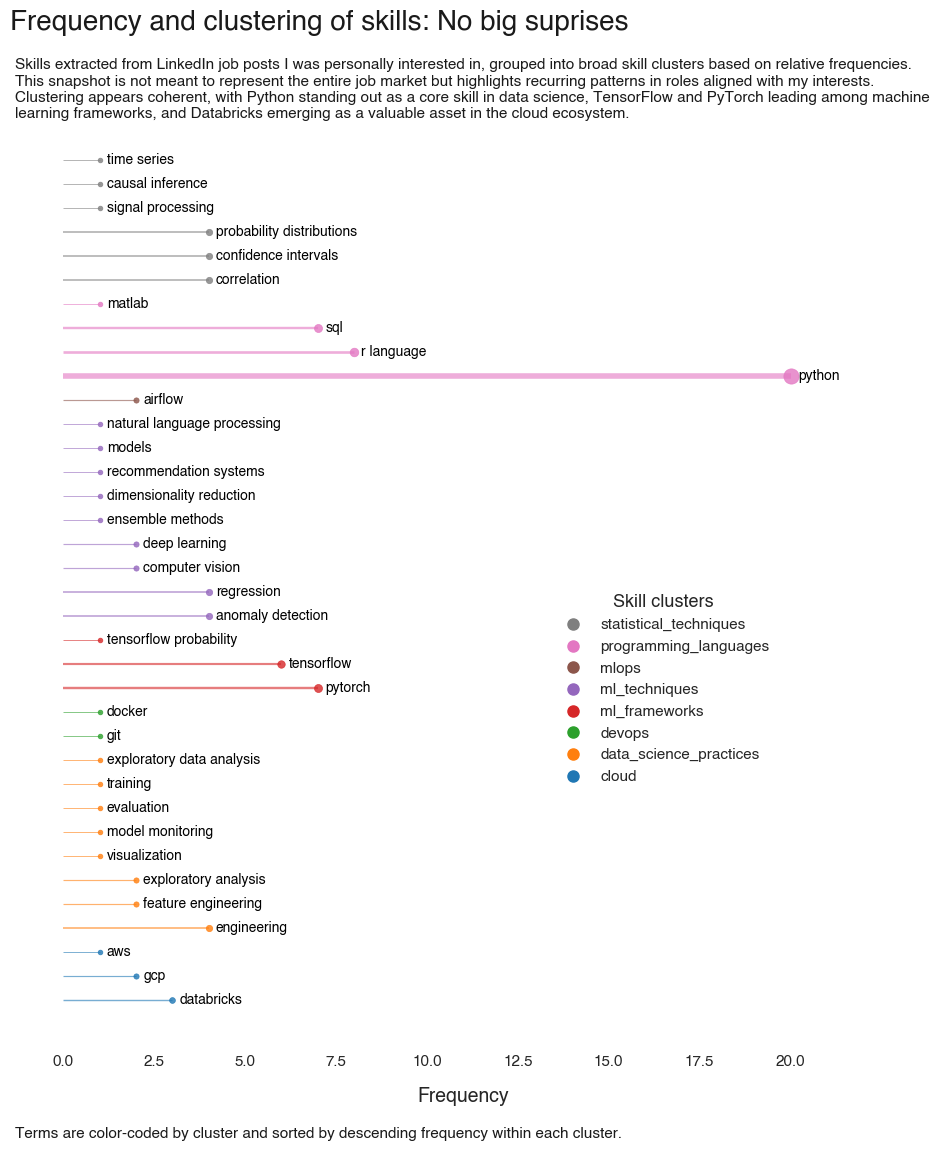

In [18]:
sns.set_style("white")
plot_lollipop_chart(skill_df[skill_df['cluster'] != 'Other'], False)

### Estimate skills co-occurence and domain clusters

Using raw co-occurrence counts can be misleading because common terms will co-occur with everything. Pointwise Mutual Information (PMI) — or better yet its normalised cousin NPMI — adjusts for term prevalence and highlights unexpected associations.

Specifically, NPMI brings the following benefits:

   * **Adjusts for popularity**: Two very common skills (e.g. “Python” and “SQL”) co‑occur frequently simply because both appear often.  NPMI down‑weights that effect.
   * **Bounds and comparability**: Raw counts or PMI can be unbounded, making it hard to compare across pairs.  NPMI’s $[-1,1]$ range standardises association strength.
   * **Bias toward rare events mitigated**: Normalisation penalises pairs whose joint probability $P(i,j)$ is very small, reducing the influence of spurious coincidences.
<br />
<br />
<br />
<br />

Skill co‑occurrence and domain clusters via normalized pointwise mutual information (NPMI) is calculated as follows:
<br />
1. **Create binary document–term matrix**
   Each job posting is represented as a binary vector over the vocabulary of skills:

   $$
     d_{m,i} = 
     \begin{cases}
       1 & \text{if skill }i\text{ appears in document }m,\\
       0 & \text{otherwise.}
     \end{cases}
   $$

<br /><br />

2. **Estimate marginal and joint probabilities**
   Over a corpus of $M$ documents,

   $$
     P(i) \;=\; \frac{1}{M}\sum_{m=1}^M d_{m,i}, 
     \quad
     P(i,j) \;=\; \frac{1}{M}\sum_{m=1}^M d_{m,i}\,d_{m,j}.
   $$

<br /><br />

3. **Compute Pointwise Mutual Information (PMI)**
   PMI measures how much more often two skills co‑occur than if they were independent:

   $$
     \mathrm{PMI}(i,j)\;=\;\log\frac{P(i,j)}{P(i)\,P(j)}.
   $$

<br /><br />

4. **Normalise to NPMI**
   Raw PMI can be unbounded and biased toward rare events.  Normalised PMI rescales it into $[-1,1]$:

   $$
     \mathrm{NPMI}(i,j)
     \;=\;
     \frac{\mathrm{PMI}(i,j)}{-\log P(i,j)}
     \;=\;
     \frac{\log \!\bigl(\tfrac{P(i,j)}{P(i)\,P(j)}\bigr)}{-\log P(i,j)}.
   $$

   * **$+1$** indicates perfect co‑occurrence (always together).
   * **$0$** indicates statistical independence.
   * **$-1$** indicates complete mutual exclusion.

<br /><br />

5. **Hierarchical clustering**
   We convert similarity (NPMI) to a distance via

   $$
     d(i,j) = 1 - \mathrm{NPMI}(i,j),
   $$

   then apply agglomerative clustering to discover coherent skill‐domain groupings (e.g. data engineering, statistical analysis, ML) for downstream stability and transversality analysis.


In [19]:
# Select key terms for co-occurrence analysis
sel_filtered = filter_other_terms_normalised(filtered, skill_df, _normalise)

In [29]:

#  compute the NPMI matrix and clusters
npmi_df = compute_npmi_from_filtered(sel_filtered)
clusters = term_clusters(npmi_df, num_clusters=13)


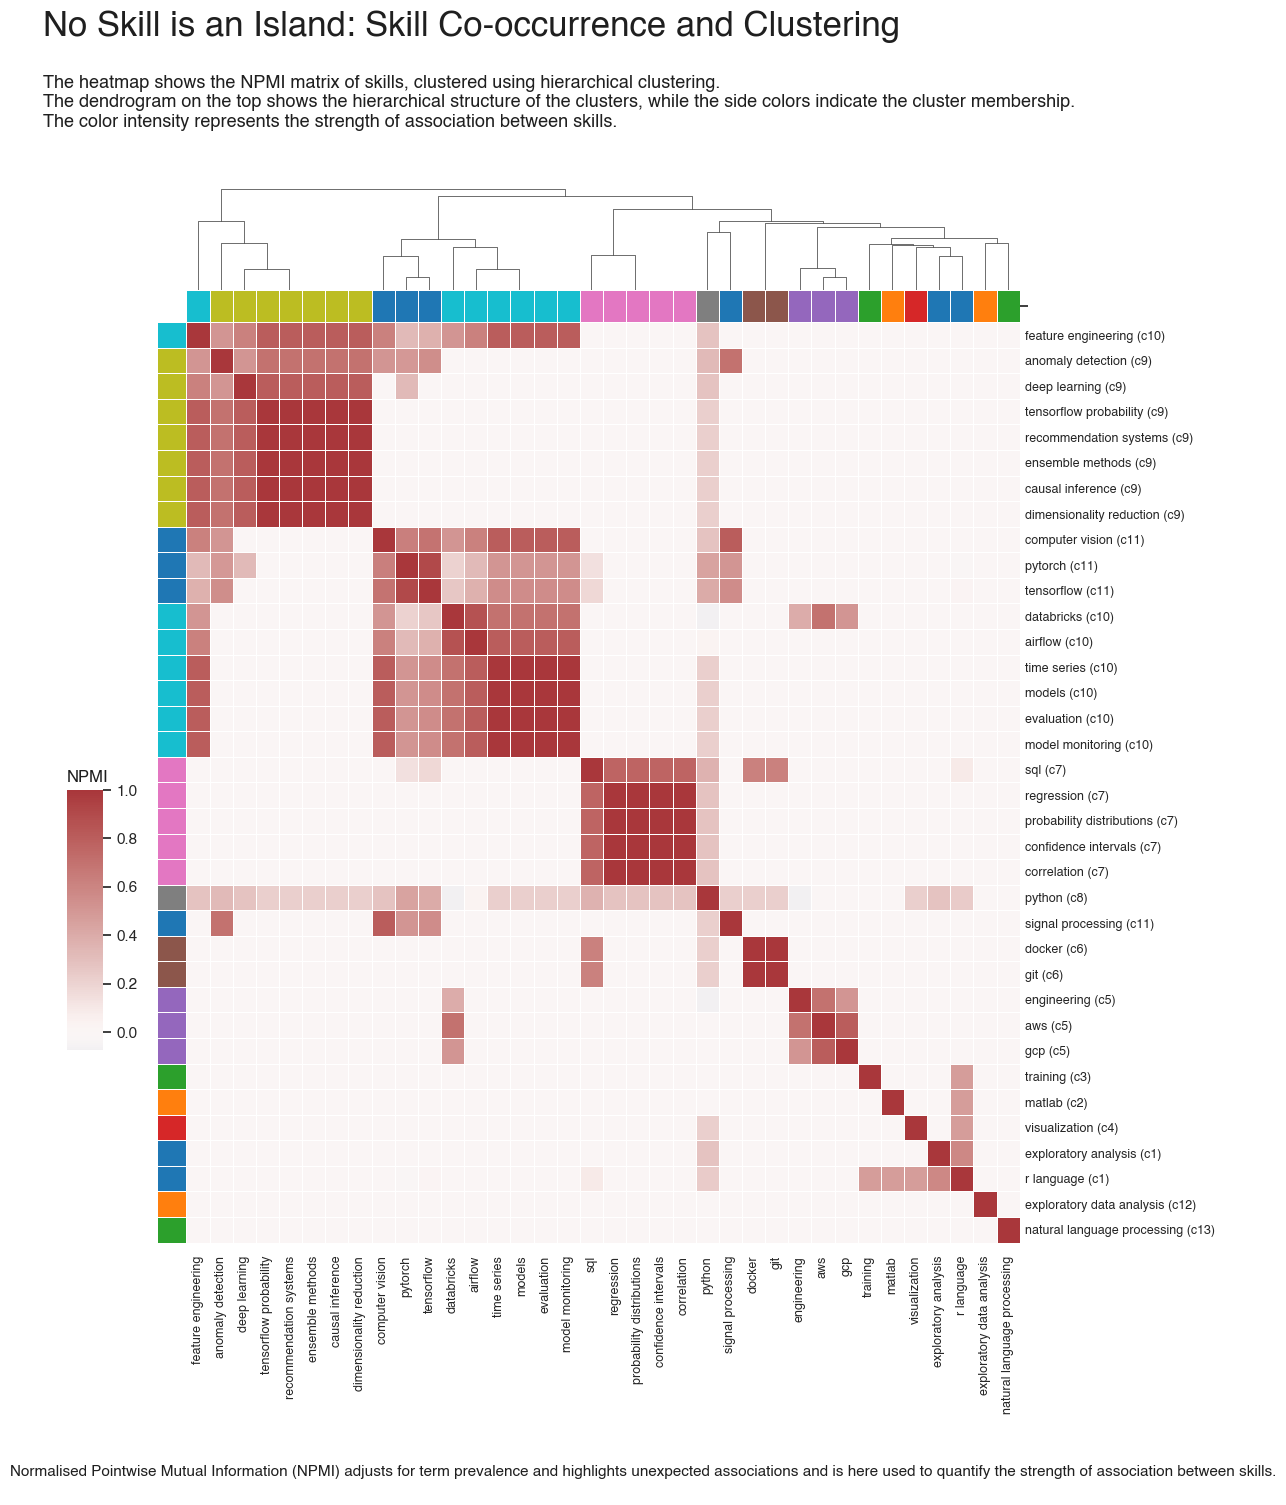

In [ ]:

title = 'No Skill is an Island: Skill Co-occurrence and Clustering'
sup_title = ("The heatmap shows the NPMI matrix of skills, clustered using hierarchical clustering.\n"
             "The dendrogram on the top shows the hierarchical structure of the clusters, while the side colors indicate the cluster membership.\n"
             "The color intensity represents the strength of association between skills. ")
footer = "Normalised Pointwise Mutual Information (NPMI) adjusts for term prevalence and highlights unexpected associations and is here used to quantify the strength of association between skills.\n"
plot_npmi_clusters(npmi_df, clusters, title, sup_title, footer, save_plot=False)

### Cluster stability analysis via document‐level bootstrapping

When we apply hierarchical clustering to an NPMI matrix, we always obtain some partition of terms, even if the underlying co‐occurrence structure is weak or spurious. To assess which clusters reflect genuine patterns rather than sampling variability, we can use a non-parametric bootstrap approach.

Specifically, we can resample the documents with replacement, recompute the NPMI matrix for each bootstrap replicate, re-cluster, and then ask *“how often do the same terms get grouped together?”* Clusters that repeatedly appear across many replicates (e.g., 90%-100%) are more likely to reflect real structure.

Note:  computationally expensive &rarr; O(n_terms²·n_docs)

In [21]:
for cluster_num, terms in clusters.groupby(clusters.values):
    print(f"\nCluster {cluster_num}:")
    for term in terms.index:
        print(f" - {term}")


Cluster 1:
 - exploratory analysis
 - r language

Cluster 2:
 - matlab

Cluster 3:
 - training

Cluster 4:
 - visualization

Cluster 5:
 - aws
 - engineering
 - gcp

Cluster 6:
 - docker
 - git

Cluster 7:
 - confidence intervals
 - correlation
 - probability distributions
 - regression
 - sql

Cluster 8:
 - python

Cluster 9:
 - anomaly detection
 - causal inference
 - deep learning
 - dimensionality reduction
 - ensemble methods
 - recommendation systems
 - tensorflow probability

Cluster 10:
 - airflow
 - databricks
 - evaluation
 - feature engineering
 - model monitoring
 - models
 - time series

Cluster 11:
 - computer vision
 - pytorch
 - signal processing
 - tensorflow

Cluster 12:
 - exploratory data analysis

Cluster 13:
 - natural language processing


In [22]:
# Compute original NPMI and get term→cluster Series
npmi_df = compute_npmi_from_filtered(sel_filtered)
clusters: pd.Series = term_clusters(npmi_df, num_clusters=13)

# Invert to cluster→list of terms
cluster_to_terms: dict[int, list[str]] = defaultdict(list)
for term, cid in clusters.items():
    cluster_to_terms[cid].append(term)

# Bootstrap stability matrix
P = bootstrap_cluster_stability(filtered, num_clusters=13, n_reps=200)

# Compute stability per cluster
for cid, members in cluster_to_terms.items():
    sub = P.loc[members, members]
    iu = np.triu_indices_from(sub, k=1)
    stability_score = sub.values[iu].mean()
    print(f"Cluster {cid} ({len(members)} terms) stability: {stability_score:.2f}")


Cluster 10 (7 terms) stability: 0.96
Cluster 9 (7 terms) stability: 0.99
Cluster 5 (3 terms) stability: 0.96
Cluster 11 (4 terms) stability: 0.97
Cluster 7 (5 terms) stability: 0.99
Cluster 6 (2 terms) stability: 0.97
Cluster 1 (2 terms) stability: 0.95
Cluster 12 (1 terms) stability: nan
Cluster 2 (1 terms) stability: nan
Cluster 13 (1 terms) stability: nan
Cluster 8 (1 terms) stability: nan
Cluster 3 (1 terms) stability: nan
Cluster 4 (1 terms) stability: nan


/var/folders/mv/fvpjl0kn36g4b6ymmckwnwbc0000gn/T/ipykernel_5706/3554941754.py:17: RuntimeWarning: Mean of empty slice.
  stability_score = sub.values[iu].mean()
/Users/ale/Documents/Projects/Py/Portfolio/linkedin-job-analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/mv/fvpjl0kn36g4b6ymmckwnwbc0000gn/T/ipykernel_5706/3554941754.py:17: RuntimeWarning: Mean of empty slice.
  stability_score = sub.values[iu].mean()
/Users/ale/Documents/Projects/Py/Portfolio/linkedin-job-analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/mv/fvpjl0kn36g4b6ymmckwnwbc0000gn/T/ipykernel_5706/3554941754.py:17: RuntimeWarning: Mean of empty slice.
  stability_score = sub.values[iu].mean()
/Users/ale/Documents/Projects/Py/Portfolio/linkedin-job-analysis/.v

### Estimate transversality scores for each skill

The metric of **Transversality** aims to highlight skills that **bridge** multiple domains, those whose co‑occurrence strength is not confined to a single cluster, making it a robust indicator of cross‑domain importance.
<br /><br />
Transversality is calculated as the Shannon entropy of its normalised affinities across the identified, stable domain clusters following the steps below:

1. **Cluster‑affinity sums**
   Given a set of $K$ clusters and an NPMI matrix $\mathrm{NPMI}(i,j)$, let

   $$
     S_{i,c}
     \;=\;
     \sum_{j \in \text{Cluster }c}
     \mathrm{NPMI}(i,j)
   $$

   be the total association strength of skill $i$ to cluster $c$.
<br /><br />
2. **Normalise to a distribution**
   Convert $\{S_{i,1},\dots,S_{i,K}\}$ into a probability vector

   $$
     p_{i,c}
     \;=\;
     \frac{S_{i,c}}{\sum_{c'=1}^{K} S_{i,c'}}
     \quad\text{so that}\quad
     \sum_{c=1}^K p_{i,c} = 1.
   $$
<br /><br />
3. **Compute Shannon entropy**

   $$
     H(i)
     \;=\;
     -\,\sum_{c=1}^{K}
     p_{i,c}\,\log p_{i,c}.
   $$

   * $H(i)=0$ if all affinity mass is concentrated in one cluster (fully specialized).
   * $H(i)$ is maximized when $p_{i,c}=1/K$ for all $c$ (perfectly transversal).


<br /><br />

**Rationale: Why entropy as transversality?**

   * **Captures spread**: Entropy directly quantifies how evenly a skill’s associations are distributed across domains.
   * **Scale‑free**: By normalising affinities, we avoid biases from absolute frequency—focus remains on relative cross‑cluster reach.
   * **Intuitive bounds**: $0 \le H(i) \le \log K$; one can even normalise by $\log K$ to get a \[0,1] transversality score.


In [23]:
# Compute transversal scores
trans_scores = transversal_scores_on_stable_clusters(
    npmi=npmi_df,
    stability_matrix=P,
    clusters=cluster_to_terms,
    stability_threshold=0.9
)

In [24]:
trans_scores.sort_values(ascending=False).head(10)

python                 1.690816
pytorch                1.075302
tensorflow             1.051554
feature engineering    0.974869
databricks             0.919897
sql                    0.887828
anomaly detection      0.871590
computer vision        0.814761
git                    0.665668
docker                 0.665668
dtype: float64

### Top bridging skills

(<Figure size 900x900 with 2 Axes>, <PolarAxes: >)

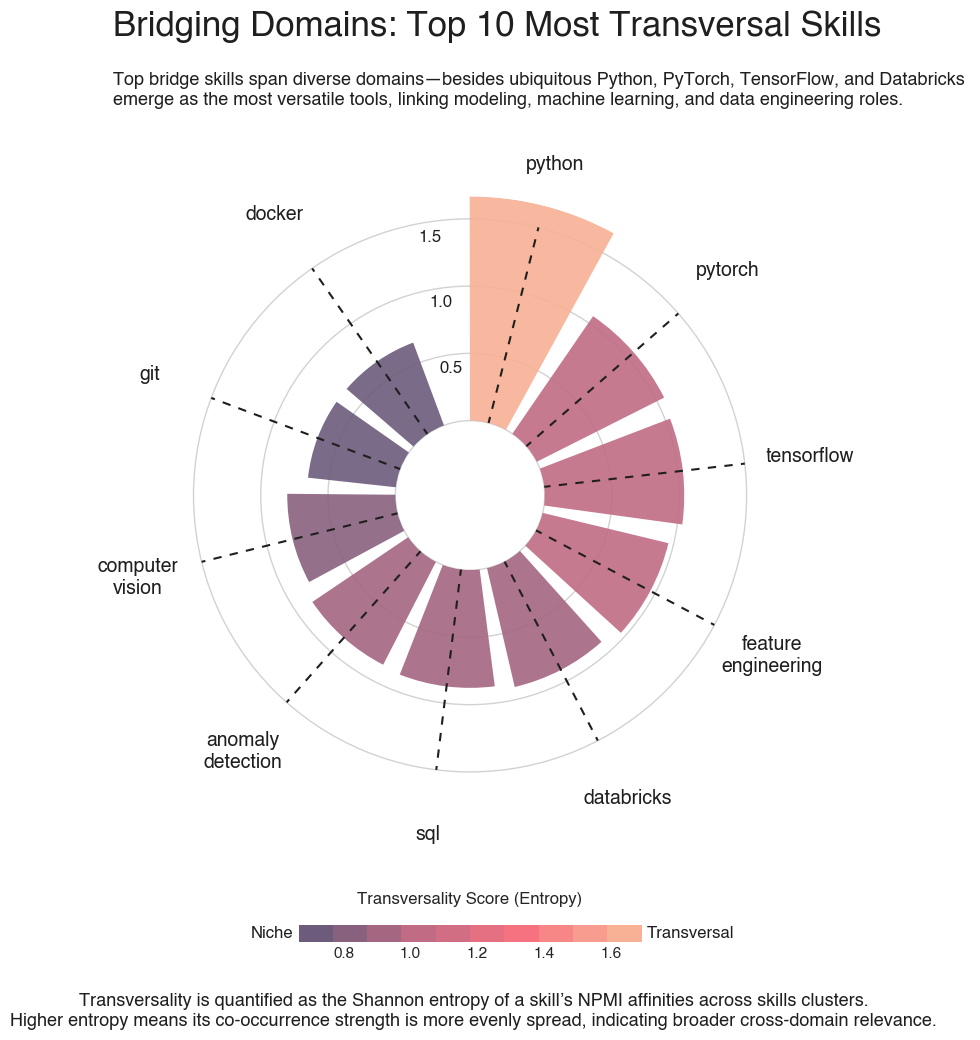

In [ ]:
sns.set_theme()
title = "Bridging Domains: Top 10 Most Transversal Skills"
sup_title = 'Top bridge skills span diverse domains—besides ubiquitous Python, PyTorch, TensorFlow, and Databricks \nemerge as the most versatile tools, linking modeling, machine learning, and data engineering roles.'
footer = "Transversality is quantified as the Shannon entropy of a skill’s NPMI affinities across skills clusters.\nHigher entropy means its co‑occurrence strength is more evenly spread, indicating broader cross‑domain relevance."
plot_top_transversal_skills(trans_scores, top_n=10, title=title, sup_title=sup_title, footer=footer, save_plot=False)